In [2]:
import scanpy as sc
import os
import pandas as pd
import numpy as np

import celltypist
from celltypist import models
os.listdir("../dataset/rawdataset")

['.ipynb_checkpoints',
 'GSE144744',
 'GSE138266_RAW',
 'GSE194078_RAW.tar',
 'GSE194078_RAW',
 'GSE227954_RAW',
 'GSE227954_meta.csv',
 'gse227954_cleaned_with_meta.rds',
 'Untitled.ipynb',
 'GSE138266.h5ad',
 'gse104078.finale.h5ad',
 'GSE227954_RAW.tar',
 'GSE138266_CSF.h5ad',
 'gse104078.finale.csf.h5ad']

In [3]:
# PREPROCESSING GSE144744

gse144744 = sc.read_10x_mtx("../dataset/rawdataset/GSE144744/RNA_counts")
gse144744_metadata = pd.read_csv("../dataset/rawdataset/GSE144744/GSE144744_metadata_per_cell.csv")
gse144744.obs = gse144744_metadata
adata = gse144744

In [5]:
def process_adata(adata):
    print(adata)
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Logarithmize the data
    sc.pp.log1p(adata)
    # Mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], inplace=True, log1p=True
    )
    # Filtering
    sc.pp.filter_cells(adata, max_genes=3000)  # Keeps cells with at least 3000 features
    sc.pp.filter_cells(adata, max_counts=7000)  # Keeps cells with at most 7000 total RNA counts
    sc.pp.filter_cells(adata, min_genes=100)
    adata = adata[adata.obs['pct_counts_mt'] < 15, :]
    adata.layers["counts"] = adata.X.copy()
    # Normalizing to median total counts
    adata.obs['condition'] = np.where(adata.obs['disease_onset'].isna(), 'CTRL', 'MS')
    return adata

def annotate_adata(adata):
    predictions = celltypist.annotate(adata.copy(), model = 'Healthy_COVID19_PBMC.pkl', majority_voting = True)
    adata.obs = pd.concat([adata.obs, predictions.predicted_labels], axis=1)
    return adata

In [6]:
def split_anndata_by_column_array(adata, column_name):
    """
    Splits an AnnData object into a list of AnnData objects based on unique values in the given column.

    Parameters:
    - adata: AnnData
    - column_name: str, name of the column in adata.obs

    Returns:
    - List of AnnData objects, each corresponding to one unique value in the column
    """
    unique_values = adata.obs[column_name].unique()
    split_list = [adata[adata.obs[column_name] == value].copy() for value in unique_values]
    return split_list
adata_list = split_anndata_by_column_array(adata, 'sample')

In [7]:
adata_list_annotata = []
for single_adata in adata_list:
    single_adata.layers["counts"] = single_adata.X.copy()
    single_adata = process_adata(single_adata)
    single_adata = annotate_adata(single_adata)
    adata_list_annotata.append(single_adata)
adata_list = adata_list_annotata

AnnData object with n_obs × n_vars = 12176 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 12136 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 11536 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 11501 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 15885 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 15813 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 10931 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 10916 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 15973 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 15959 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 11159 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 11113 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 11236 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 11215 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 12644 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 12599 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 18512 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 18503 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 11098 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 11096 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 11345 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 11344 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 13233 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 13231 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 12504 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 12490 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 12928 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 12910 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 13004 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 12984 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 15865 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 15855 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 15416 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 15405 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 12120 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 12111 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 12822 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 12810 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 14955 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 14936 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 3011 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 2982 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 2348 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 2304 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 3674 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 3618 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 3067 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 2994 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 2729 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 2676 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 4110 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 4044 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 5188 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 5116 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 5146 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 5077 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 5796 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 5720 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 4617 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 4541 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 3193 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 3121 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 4711 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 4674 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 3890 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 3836 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 2264 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 2209 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 4732 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 4703 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 4926 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 4837 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 3768 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 3743 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 3945 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 3906 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 4304 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 4261 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 4206 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 4186 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 1386 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 1373 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 3027 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 2968 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 2406 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 2374 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 3505 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 3476 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 2703 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 2695 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 4544 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 4489 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 3655 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 3630 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 4206 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 4175 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 4431 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 4408 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 7446 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 7381 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 7791 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 7731 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 4993 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 4687 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 10486 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 10442 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 6203 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 6189 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 5657 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 5632 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 6732 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 6728 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 6750 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 6737 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 5966 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 5941 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 955 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 954 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 1997 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 1997 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 790 cells and 15354 genes
🔗 Matching reference genes in the model


AnnData object with n_obs × n_vars = 790 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 1941 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 1940 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 2578 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 2577 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 2995 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 2992 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 1925 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 1925 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 11882 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 11878 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 7283 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 7283 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 4971 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 4971 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 13220 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 13220 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 5136 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 5136 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 5178 × 15354
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment'
    var: 'gene_ids'
    layers: 'counts'


🔬 Input data has 5177 cells and 15354 genes
🔗 Matching reference genes in the model
🧬 2955 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [6]:
import anndata
adata = anndata.concat(adata_list, join='inner', merge="same")


In [7]:
import numpy as np
def remove_zero_expressed_genes(adata):
  """
  Removes genes with zero expression in all cells from an AnnData object.

  Args:
    adata: An AnnData object.

  Returns:
    An AnnData object with zero-expressed genes removed.
  """
  # Calculate the mean expression for each gene
  gene_means = adata.X.mean(axis=0)
  
  # Identify genes with zero mean expression
  zero_expressed_genes = gene_means == 0

  # Get the indices of the genes to keep
  genes_to_keep = ~zero_expressed_genes

  # Subset the AnnData object to keep only the genes with non-zero expression
  adata = adata[:, genes_to_keep]

  print(f"Removed {np.sum(zero_expressed_genes)} genes with zero expression.")
  return adata
adata = remove_zero_expressed_genes(adata)
print(adata)

Removed 4 genes with zero expression.
View of AnnData object with n_obs × n_vars = 495371 × 15350
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'condition', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'mt'
    layers: 'counts'


... storing 'donor' as categorical
... storing 'sample' as categorical
... storing 'sample_10X' as categorical
... storing 'HASH' as categorical
... storing 'match' as categorical
... storing 'batch_pair' as categorical
... storing 'group' as categorical
... storing 'cohort' as categorical
... storing 'V_10X' as categorical
... storing 'exp_name' as categorical
... storing 'basictype' as categorical
... storing 'cluster_names' as categorical
... storing 'sample_date' as categorical
... storing 'sex' as categorical
... storing 'prev_treatments' as categorical
... storing 'natalizumab_treatment' as categorical
... storing 'condition' as categorical


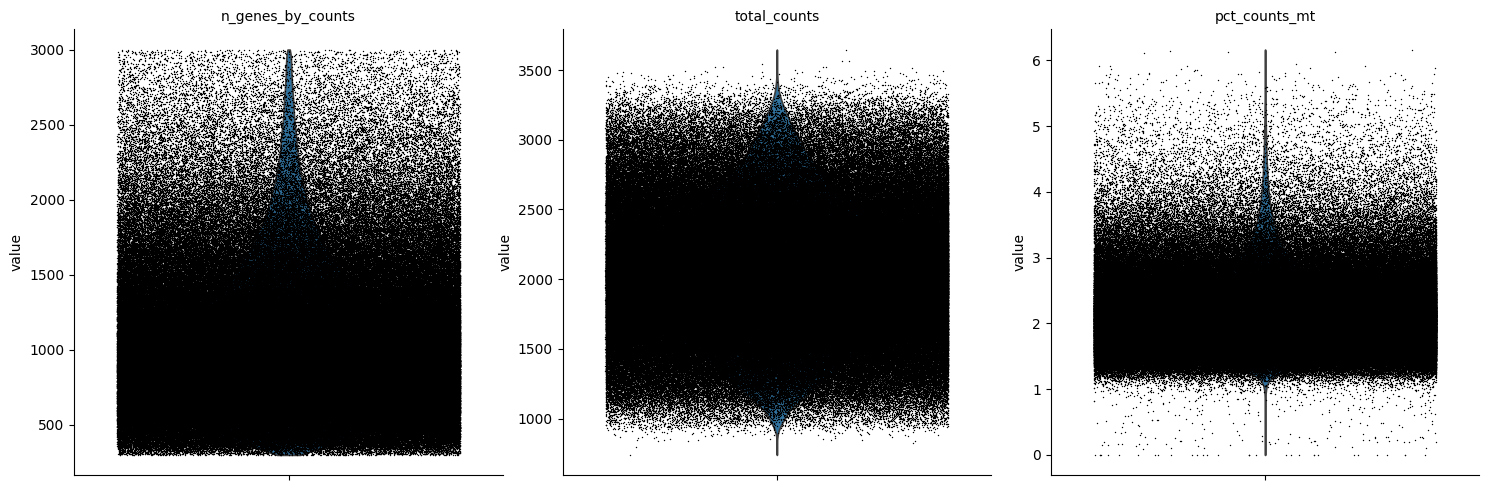

In [8]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

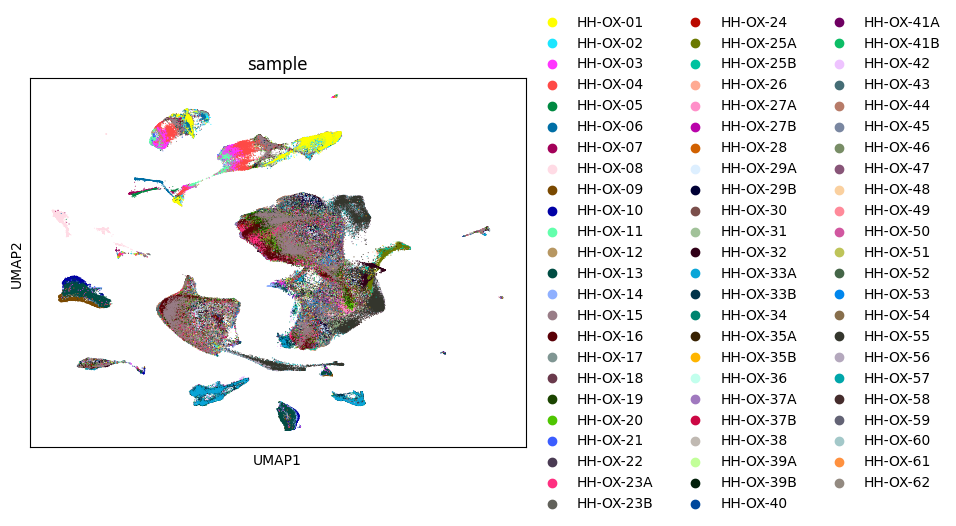

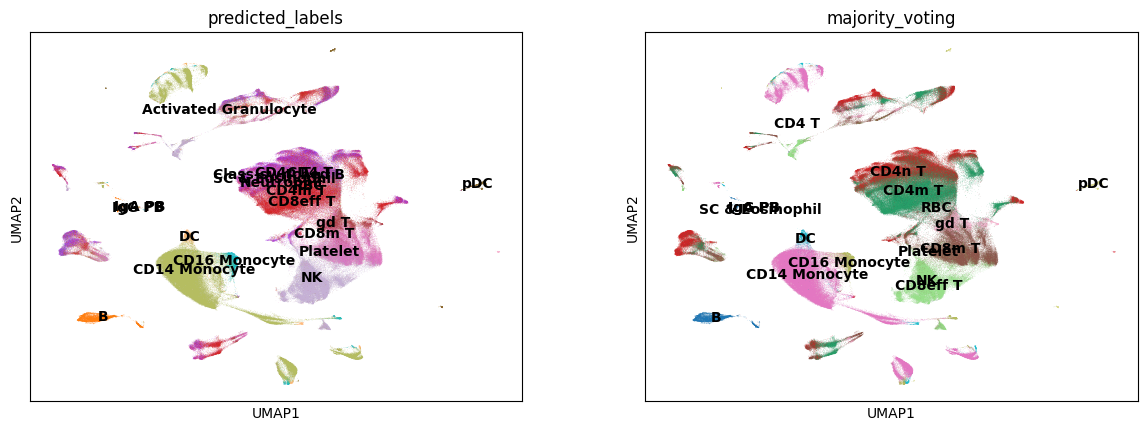

In [9]:
rsc.tl.pca(adata, svd_solver='arpack', n_comps=50)
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
rsc.tl.umap(adata, min_dist=0.3, spread=1.0)

sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

sc.pl.umap(adata, color = ['predicted_labels', 'majority_voting'], legend_loc = 'on data')

In [10]:
adata.write("dataset/rawdataset/GSE144744/anndata.h5ad", compression="gzip")

In [11]:
adata

AnnData object with n_obs × n_vars = 495371 × 15350
    obs: 'cell_names', 'donor', 'sample', 'sample_10X', 'HASH', 'match', 'batch_pair', 'group', 'cohort', 'V_10X', 'exp_name', 'nFeature_RNA', 'nCount_RNA', 'nCount_ADT', 'percent_mito', 'basictype', 'cluster_names', 'sample_date', 'birth_year', 'age_sampling', 'sex', 'EDSS', 'MRI_n_CE_lesions', 'disease_onset', 'prev_treatments', 'natalizumab_treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'condition', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'mt'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', 'predicted_labels_colors', 'majority_voting_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connec